In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16, NASNetLarge, Xception, InceptionResNetV2, DenseNet169

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

Using TensorFlow backend.


## Import dataset and balance data

In [3]:
df = pd.read_csv(r"./input/newTrainLabels.csv")
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


In [4]:
df['level'] = 1*(df['level'] > 0)
df.head(10)

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906
5,15_right,1,0.138600
6,16_left,1,0.151041
7,16_right,1,0.153951
8,17_left,0,0.169070
9,17_right,1,0.174882


In [5]:
df['level'].value_counts()

0    25808
1     9316
Name: level, dtype: int64

In [6]:
g = df.groupby('level')
df = g.apply(lambda x: x.sample(2000).reset_index(drop=True))

In [7]:
df['level'].value_counts()

1    2000
0    2000
Name: level, dtype: int64

In [8]:
X = df.image
y = df.level

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx,test_idx in stratSplit.split(X, y):
    X_train=X[train_idx]
    y_train=y[train_idx]
    X_val=X[test_idx]
    y_val=y[test_idx]
    
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

In [10]:
df_test = pd.read_csv(r"./input/retinopathy_solution.csv")
df_test.head()

,image,level,Usage
0,1_left,0,Private
1,1_right,0,Private
2,2_left,0,Public
3,2_right,0,Public
4,3_left,2,Private


In [11]:
df_test['level'] = 1*(df_test['level'] > 0)

In [12]:
df_test['level'].value_counts()

0    39533
1    14043
Name: level, dtype: int64

In [13]:
g_test = df_test.groupby('level')
df_test = g_test.apply(lambda x: x.sample(10000).reset_index(drop=True))

In [14]:
df_test['level'].value_counts()

1    10000
0    10000
Name: level, dtype: int64

## Define generators

In [15]:
# Data directory
train_dir = "./input/300_train"
validation_dir = "./input/300_train"
test_dir = "./input/300_test"

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=[0.9, 1.1],
    rotation_range=360,
    shear_range=0.2,
    fill_mode='nearest')

# train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

batchSize = 50
targetSize = (150,150)

train_generator = train_datagen.flow_from_dataframe(
        target_size=targetSize,
        batch_size=batchSize,
        class_mode='binary',
        dataframe = df_train, 
        directory = train_dir,
        has_ext = False,
        x_col = "image", 
        y_col = "level")

validation_generator = val_test_datagen.flow_from_dataframe(
        target_size=targetSize,
        batch_size=batchSize,
        class_mode='binary',
        dataframe = df_val, 
        directory = validation_dir,
        has_ext = False,
        x_col = "image", 
        y_col = "level")

test_generator = val_test_datagen.flow_from_dataframe(
        target_size=targetSize,
        batch_size=batchSize,
        class_mode='binary',
        dataframe = df_test, 
        directory = test_dir,
        has_ext = False,
        x_col = "image", 
        y_col = "level")

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Design Model

### Model 1 : 4-Conv

In [15]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        36928     
__________

### Model 2 : 3-Conv

In [16]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model1.add(layers.Dropout(0.2))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9248)              0         
__________

### Model 3 : VGG16 - Pretraining model

In [16]:
vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
vgg_base.trainable = False

model3 = models.Sequential()
model3.add(vgg_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Model 4 : 4-Conv with double layers

In [17]:
model4 = models.Sequential()
# this applies 32 convolution filters of size 3x3 each.
# See: https://keras.io/getting-started/sequential-model-guide/ -> VGG-like convnet
model4.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model4.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model4.add(layers.MaxPooling2D(pool_size = (2, 2)))
model4.add(layers.Dropout(0.25))

model4.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model4.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model4.add(layers.MaxPooling2D(pool_size = (2, 2)))
model4.add(layers.Dropout(0.25))

model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation = 'relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(1, activation = 'sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(optimizer = sgd,
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
__________

# Train model

In [19]:
# Create callback list for model fitting
weight_path_model1="kaggle_weights_model1.best.hdf5"
weight_path_model2="kaggle_weights_model2.best.hdf5"
weight_path_model3="kaggle_weights_model3.best.hdf5"
weight_path_model4="kaggle_weights_model4.best.hdf5"

checkpoint1 = ModelCheckpoint(weight_path_model1, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
checkpoint2 = ModelCheckpoint(weight_path_model2, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
checkpoint3 = ModelCheckpoint(weight_path_model3, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
checkpoint4 = ModelCheckpoint(weight_path_model4, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

callbacks_list1 = [checkpoint1]
callbacks_list2 = [checkpoint2]
callbacks_list3 = [checkpoint3]
callbacks_list4 = [checkpoint4]

step_train = 3000//batchSize
step_val = 1000//batchSize

### Train model 1 : 4-Conv

In [ ]:
history1 = model1.fit_generator(
    train_generator,
    steps_per_epoch = step_train,
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list1,
    validation_data = validation_generator,
    validation_steps = step_val)

Epoch 1/100
60/60 [==============================] - 95s 2s/step - loss: 2.1870 - acc: 0.4947 - val_loss: 0.7320 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.73203, saving model to kaggle_weights_model1.best.hdf5
Epoch 2/100
60/60 [==============================] - 40s 664ms/step - loss: 2.0318 - acc: 0.5040 - val_loss: 0.7225 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.73203 to 0.72249, saving model to kaggle_weights_model1.best.hdf5
Epoch 3/100
60/60 [==============================] - 41s 686ms/step - loss: 2.0904 - acc: 0.4873 - val_loss: 0.7125 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.72249 to 0.71248, saving model to kaggle_weights_model1.best.hdf5
Epoch 4/100
60/60 [==============================] - 42s 707ms/step - loss: 2.2744 - acc: 0.4993 - val_loss: 0.7350 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.71248
Epoch 5/100
60/60 [==============================] - 43s 716ms/step - loss: 2.1922 - acc: 0.5080 - val_l

60/60 [==============================] - 42s 706ms/step - loss: 2.1277 - acc: 0.5283 - val_loss: 0.7700 - val_acc: 0.5000

Epoch 00044: val_loss did not improve from 0.71232
Epoch 45/100
60/60 [==============================] - 42s 700ms/step - loss: 2.0848 - acc: 0.5360 - val_loss: 0.7380 - val_acc: 0.5010

Epoch 00045: val_loss did not improve from 0.71232
Epoch 46/100
60/60 [==============================] - 42s 706ms/step - loss: 2.0467 - acc: 0.5253 - val_loss: 0.7139 - val_acc: 0.4980

Epoch 00046: val_loss did not improve from 0.71232
Epoch 47/100
60/60 [==============================] - 43s 710ms/step - loss: 2.2711 - acc: 0.5223 - val_loss: 0.7445 - val_acc: 0.5010

Epoch 00047: val_loss did not improve from 0.71232
Epoch 48/100
60/60 [==============================] - 42s 708ms/step - loss: 2.1065 - acc: 0.5310 - val_loss: 0.7219 - val_acc: 0.5000

Epoch 00048: val_loss did not improve from 0.71232
Epoch 49/100
60/60 [==============================] - 43s 714ms/step - loss: 2


Epoch 00087: val_loss did not improve from 0.70870
Epoch 88/100
60/60 [==============================] - 41s 686ms/step - loss: 2.0678 - acc: 0.5613 - val_loss: 0.7160 - val_acc: 0.4890

Epoch 00088: val_loss did not improve from 0.70870
Epoch 89/100
60/60 [==============================] - 42s 700ms/step - loss: 2.1063 - acc: 0.5647 - val_loss: 0.7594 - val_acc: 0.4980

Epoch 00089: val_loss did not improve from 0.70870
Epoch 90/100
60/60 [==============================] - 42s 698ms/step - loss: 2.2689 - acc: 0.5427 - val_loss: 0.7332 - val_acc: 0.4970

Epoch 00090: val_loss did not improve from 0.70870
Epoch 91/100
60/60 [==============================] - 40s 675ms/step - loss: 2.2287 - acc: 0.5563 - val_loss: 0.7409 - val_acc: 0.4970

Epoch 00091: val_loss did not improve from 0.70870
Epoch 92/100
60/60 [==============================] - 40s 661ms/step - loss: 2.1501 - acc: 0.5457 - val_loss: 0.7293 - val_acc: 0.4910

Epoch 00092: val_loss did not improve from 0.70870
Epoch 93/100


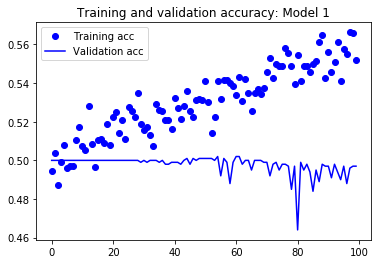

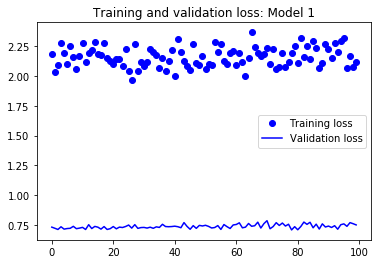

In [ ]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: Model 1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: Model 1')
plt.legend()

plt.show()

### Train model 2 : 3-Conv

In [ ]:
history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch = step_train,
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list2,
    validation_data = validation_generator,
    validation_steps = step_val)

Epoch 1/100
60/60 [==============================] - 43s 723ms/step - loss: 0.6965 - acc: 0.5017 - val_loss: 0.6957 - val_acc: 0.4940

Epoch 00001: val_loss improved from inf to 0.69567, saving model to kaggle_weights_model2.best.hdf5
Epoch 2/100
60/60 [==============================] - 38s 625ms/step - loss: 0.6940 - acc: 0.4847 - val_loss: 0.6934 - val_acc: 0.4880

Epoch 00002: val_loss improved from 0.69567 to 0.69336, saving model to kaggle_weights_model2.best.hdf5
Epoch 3/100
60/60 [==============================] - 38s 636ms/step - loss: 0.6934 - acc: 0.5073 - val_loss: 0.6939 - val_acc: 0.4590

Epoch 00003: val_loss did not improve from 0.69336
Epoch 4/100
60/60 [==============================] - 38s 636ms/step - loss: 0.6937 - acc: 0.5090 - val_loss: 0.6943 - val_acc: 0.5020

Epoch 00004: val_loss did not improve from 0.69336
Epoch 5/100
60/60 [==============================] - 38s 640ms/step - loss: 0.6930 - acc: 0.4887 - val_loss: 0.6958 - val_acc: 0.4790

Epoch 00005: val_lo

60/60 [==============================] - 38s 638ms/step - loss: 0.6704 - acc: 0.5777 - val_loss: 0.7542 - val_acc: 0.4650

Epoch 00088: val_loss did not improve from 0.69336
Epoch 89/100
60/60 [==============================] - 38s 631ms/step - loss: 0.6688 - acc: 0.5833 - val_loss: 0.8058 - val_acc: 0.4400

Epoch 00089: val_loss did not improve from 0.69336
Epoch 90/100
60/60 [==============================] - 38s 635ms/step - loss: 0.6706 - acc: 0.5847 - val_loss: 0.7547 - val_acc: 0.4510

Epoch 00090: val_loss did not improve from 0.69336
Epoch 91/100
60/60 [==============================] - 37s 624ms/step - loss: 0.6689 - acc: 0.5837 - val_loss: 0.7814 - val_acc: 0.4400

Epoch 00091: val_loss did not improve from 0.69336
Epoch 92/100
60/60 [==============================] - 37s 617ms/step - loss: 0.6693 - acc: 0.5863 - val_loss: 0.7614 - val_acc: 0.4450

Epoch 00092: val_loss did not improve from 0.69336
Epoch 93/100
60/60 [==============================] - 38s 626ms/step - loss: 0

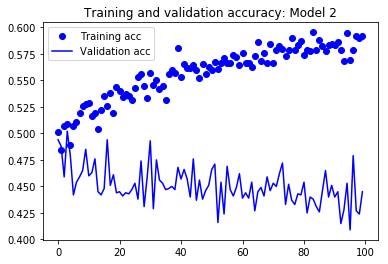

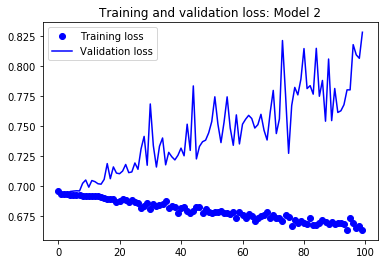

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: Model 2')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: Model 2')
plt.legend()

plt.show()

### Train model 3 : VGG16 pretraininf model

In [20]:
history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch = step_train,
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list3,
    validation_data = validation_generator,
    validation_steps = step_val)

Epoch 1/100
60/60 [==============================] - 123s 2s/step - loss: 0.7316 - acc: 0.5043 - val_loss: 0.7098 - val_acc: 0.4800

Epoch 00001: val_loss improved from inf to 0.70985, saving model to kaggle_weights_model3.best.hdf5
Epoch 2/100
60/60 [==============================] - 43s 711ms/step - loss: 0.7097 - acc: 0.5120 - val_loss: 0.7228 - val_acc: 0.4660

Epoch 00002: val_loss did not improve from 0.70985
Epoch 3/100
60/60 [==============================] - 48s 796ms/step - loss: 0.7017 - acc: 0.5240 - val_loss: 0.7296 - val_acc: 0.4690

Epoch 00003: val_loss did not improve from 0.70985
Epoch 4/100
60/60 [==============================] - 45s 757ms/step - loss: 0.6932 - acc: 0.5427 - val_loss: 0.7196 - val_acc: 0.4410

Epoch 00004: val_loss did not improve from 0.70985
Epoch 5/100
60/60 [==============================] - 47s 786ms/step - loss: 0.6902 - acc: 0.5393 - val_loss: 0.7217 - val_acc: 0.4570

Epoch 00005: val_loss did not improve from 0.70985
Epoch 6/100
60/60 [====

60/60 [==============================] - 84s 1s/step - loss: 0.6531 - acc: 0.6100 - val_loss: 0.7823 - val_acc: 0.4380

Epoch 00045: val_loss did not improve from 0.70985
Epoch 46/100
60/60 [==============================] - 84s 1s/step - loss: 0.6514 - acc: 0.6127 - val_loss: 0.7982 - val_acc: 0.4490

Epoch 00046: val_loss did not improve from 0.70985
Epoch 47/100
60/60 [==============================] - 84s 1s/step - loss: 0.6501 - acc: 0.6207 - val_loss: 0.8260 - val_acc: 0.4570

Epoch 00047: val_loss did not improve from 0.70985
Epoch 48/100
60/60 [==============================] - 84s 1s/step - loss: 0.6518 - acc: 0.6097 - val_loss: 0.7877 - val_acc: 0.4180

Epoch 00048: val_loss did not improve from 0.70985
Epoch 49/100
60/60 [==============================] - 73s 1s/step - loss: 0.6466 - acc: 0.6163 - val_loss: 0.8238 - val_acc: 0.4590

Epoch 00049: val_loss did not improve from 0.70985
Epoch 50/100
60/60 [==============================] - 63s 1s/step - loss: 0.6497 - acc: 0.609

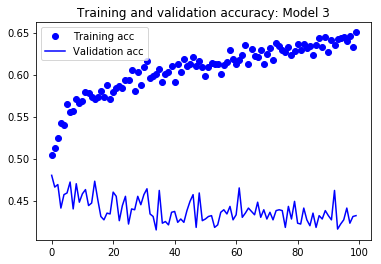

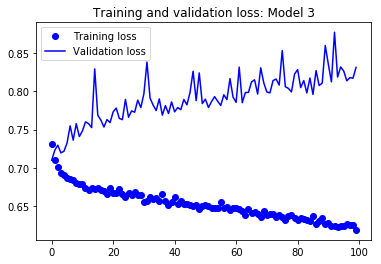

In [21]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: Model 3')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: Model 3')
plt.legend()

plt.show()

### Train model 4 : 4-Conv with double layers

In [22]:
history4 = model4.fit_generator(
    train_generator,
    steps_per_epoch = step_train,
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list4,
    validation_data = validation_generator,
    validation_steps = step_val)

Epoch 1/100
60/60 [==============================] - 53s 878ms/step - loss: 0.6951 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.4840

Epoch 00001: val_loss improved from inf to 0.69320, saving model to kaggle_weights_model4.best.hdf5
Epoch 2/100
60/60 [==============================] - 48s 794ms/step - loss: 0.6935 - acc: 0.4920 - val_loss: 0.6934 - val_acc: 0.4910

Epoch 00002: val_loss did not improve from 0.69320
Epoch 3/100
60/60 [==============================] - 49s 823ms/step - loss: 0.6933 - acc: 0.4840 - val_loss: 0.6936 - val_acc: 0.4810

Epoch 00003: val_loss did not improve from 0.69320
Epoch 4/100
60/60 [==============================] - 50s 833ms/step - loss: 0.6933 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.5080

Epoch 00004: val_loss did not improve from 0.69320
Epoch 5/100
60/60 [==============================] - 53s 890ms/step - loss: 0.6933 - acc: 0.4943 - val_loss: 0.6934 - val_acc: 0.4950

Epoch 00005: val_loss did not improve from 0.69320
Epoch 6/100
60/60 [==

60/60 [==============================] - 48s 799ms/step - loss: 0.6878 - acc: 0.5313 - val_loss: 0.7055 - val_acc: 0.4830

Epoch 00088: val_loss did not improve from 0.69284
Epoch 89/100
60/60 [==============================] - 48s 803ms/step - loss: 0.6836 - acc: 0.5550 - val_loss: 0.7209 - val_acc: 0.5010

Epoch 00089: val_loss did not improve from 0.69284
Epoch 90/100
60/60 [==============================] - 47s 777ms/step - loss: 0.6883 - acc: 0.5420 - val_loss: 0.7268 - val_acc: 0.4730

Epoch 00090: val_loss did not improve from 0.69284
Epoch 91/100
60/60 [==============================] - 47s 778ms/step - loss: 0.6851 - acc: 0.5450 - val_loss: 0.7075 - val_acc: 0.4930

Epoch 00091: val_loss did not improve from 0.69284
Epoch 92/100
60/60 [==============================] - 46s 775ms/step - loss: 0.6847 - acc: 0.5500 - val_loss: 0.7057 - val_acc: 0.4640

Epoch 00092: val_loss did not improve from 0.69284
Epoch 93/100
60/60 [==============================] - 47s 776ms/step - loss: 0

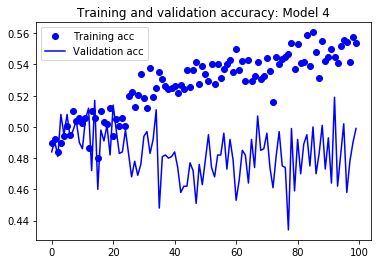

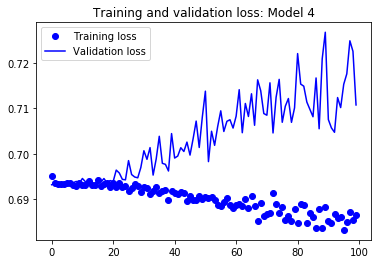

In [23]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: Model 4')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: Model 4')
plt.legend()

plt.show()